In [1]:
import tensorflow as tf
print(tf.__version__)
import yaml
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from source.image_processing import *
import numpy as np

2.0.0-beta1


In [2]:
with open("./config/coco.yml", 'r') as stream:
    meta_parameters = yaml.safe_load(stream)

DISC_UPDATE = meta_parameters['disc_update']
IMG_SIZE = meta_parameters['dataset']['img_size']
BATCH_SIZE = 1 #meta_parameters['batchsize']
BUFFER_SIZE = 2048
EPOCHS = meta_parameters['epochs']
SUMMARY_EVERY_N_STEPS = meta_parameters['summary_every_n_steps']
SAVE_EVERY_N_STEPS = meta_parameters['save_every_n_steps']
PATCH_SIZE = meta_parameters['dataset']['img_size']

In [15]:
def random_noise(input_, target):
  bound = 1. / 128
  input_ += tf.random.uniform(shape=input_.shape, minval=-bound, maxval=bound)
  target += tf.random.uniform(shape=target.shape, minval=-bound, maxval=bound)
  return input_, target

def process_tfds(features, HEIGHT, WIDTH):
  image = features["image"]
  image = tf.reshape(image, tf.shape(image))
#   image = tf.image.resize(image,
#         size=(288, 288), method=tf.image.ResizeMethod.BILINEAR,
#         preserve_aspect_ratio=True)
  image = tf.image.resize_with_crop_or_pad(image,target_height=HEIGHT+32,target_width=WIDTH+32)
  return tf.cast(image, tf.float32)

def random_crop(image, HEIGHT, WIDTH, CHANNELS=3):
  image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
  return image

def random_flip(image):
  return tf.image.random_flip_left_right(image)

def random_resize(image):
  # Random resize an image
  # For image of original size of 384x384
  # The output can have a maximum height and/or width of [461]
  # and minimum height and/or width of 307
  H, W = image.shape[:2]
  scale = tf.random.uniform([], minval=1., maxval=1.2, dtype=tf.float32, seed=None, name=None)
  shape = tf.stack((scale * W, scale * H), axis=0)
  shape = tf.cast(shape, tf.int32)
  image = tf.image.resize(image, size=shape)
  return image

In [16]:
# test_dataset = tf.data.Dataset.list_files("/home/thalles/Documents/valid_64x64/*.png")
test_dataset = tfds.load(name="cats_vs_dogs", split=tfds.Split.TRAIN)
test_dataset = test_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
test_dataset = test_dataset.map(rgb_to_lab)
test_dataset = test_dataset.map(preprocess_lab)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(1)

Range L batch -1.0 1.0
Range AB batch -0.23222315 0.5492672


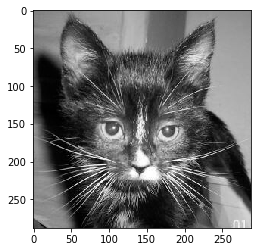

In [17]:
for L_batch, AB_batch in test_dataset.take(20):
    print("Range L batch",np.min(L_batch), np.max(L_batch))
    print("Range AB batch", np.min(AB_batch), np.max(AB_batch))
    plt.imshow(tf.squeeze(L_batch[0]), cmap="gray")
    plt.show()
    break

In [18]:
train_dataset = tfds.load(name="coco2014", split=tfds.Split.ALL)
train_dataset = train_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
train_dataset = train_dataset.map(random_resize)
train_dataset = train_dataset.map(lambda x: random_crop(x, PATCH_SIZE, PATCH_SIZE))
train_dataset = train_dataset.map(random_flip)
train_dataset = train_dataset.map(rgb_to_lab)
train_dataset = train_dataset.map(preprocess_lab)
train_dataset = train_dataset.map(random_noise)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(2)

(1, 256, 256, 1)
Range L batch -1.0078094 1.0055184
Range AB batch -0.62307143 0.85097253


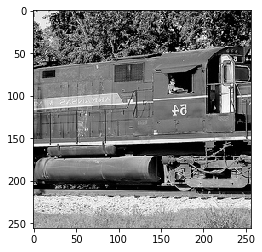

(1, 256, 256, 1)
Range L batch -1.0078114 1.0061972
Range AB batch -0.34143308 0.65025663


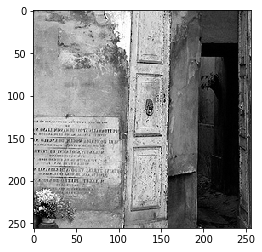

(1, 256, 256, 1)
Range L batch -0.95530224 1.0077991
Range AB batch -0.5166108 0.628582


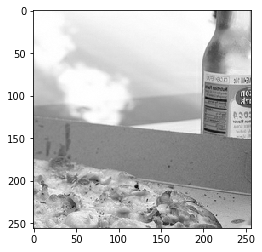

(1, 256, 256, 1)
Range L batch -0.8998465 1.0062634
Range AB batch -0.3037756 0.61862093


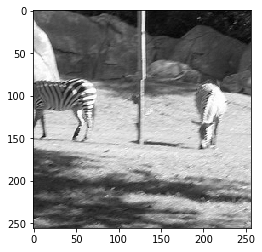

(1, 256, 256, 1)
Range L batch -1.0075626 1.006106
Range AB batch -0.2531116 0.47472557


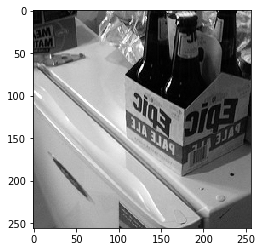

(1, 256, 256, 1)
Range L batch -1.0068309 0.8547677
Range AB batch -0.38834485 0.63047487


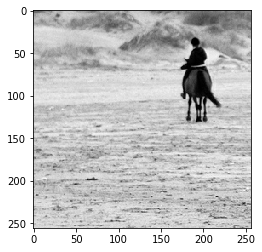

(1, 256, 256, 1)
Range L batch -1.007771 0.93456036
Range AB batch -0.08823285 0.4262092


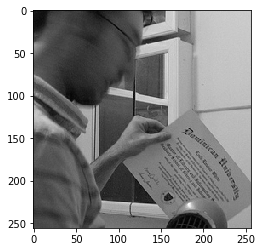

(1, 256, 256, 1)
Range L batch -1.0074569 1.0062158
Range AB batch -0.71806335 0.6534937


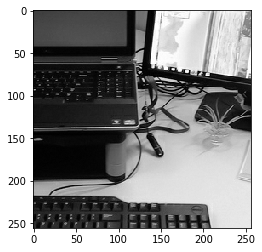

(1, 256, 256, 1)
Range L batch -1.0077652 0.998685
Range AB batch -0.26503775 0.46069002


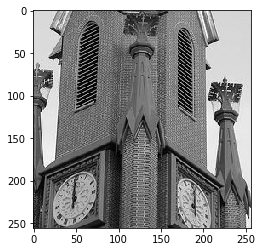

(1, 256, 256, 1)
Range L batch -1.0076437 1.0009418
Range AB batch -0.38469756 0.4029149


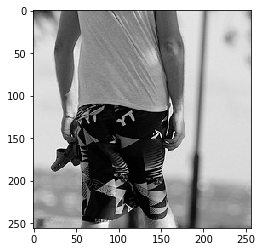

In [19]:
for L_batch, AB_batch in train_dataset.take(10):
    print(L_batch.shape)
    print("Range L batch",np.min(L_batch), np.max(L_batch))
    print("Range AB batch", np.min(AB_batch), np.max(AB_batch))
    plt.imshow(tf.squeeze(L_batch[0]), cmap="gray")
    plt.show()